In [2]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v2 import sigmoid,relu,sigmoid_backward,relu_backward,load_data

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [5]:
(train_x_orig,train_y,test_x_orig, test_y,classes) = load_data()

y = 0. It's a non-cat picture.


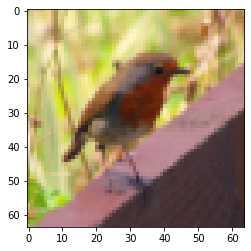

In [7]:
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [6]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [8]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


In [22]:
n_x = 12288
n_h = 7
n_y = 1
layer_dims = (n_x,n_h,n_y)

In [11]:
def initialize_parameters(n_x,n_h,n_y):
    
    W1 = np.random.randn(n_h,n_x)*0.01
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y,n_h)*0.01
    b2 = np.zeros((n_y,1))
    
    
    assert(W1.shape == (n_h,n_x))
    assert(b1.shape == (n_h,1))
    assert(W2.shape == (n_y,n_h))
    assert(b2.shape == (n_y,1))
    
    parameters = {
        "W1":W1,
        "b1":b1,
        "W2":W2,
        "b2":b2
    }
    
    return parameters

In [13]:
def linear_forward(A,W,b):
    
    Z = np.dot(W,A) + b
    assert(Z.shape == (W.shape[0],A.shape[1]))
    cache = (A,W,b)
    
    return Z,cache

In [14]:
def linear_activation_forward(A_prev,W,b,activation):
    
    if(activation == "relu"):
        Z,linear_cache = linear_forward(A_prev,W,b)
        A,activation_cache = relu(Z)
    elif(activation == "sigmoid"):
        Z,linear_cache = linear_forward(A_prev,W,b)
        A,activation_cache = sigmoid(Z)
        
    assert(A.shape == (W.shape[0],A_prev.shape[1]))
    
    cache = (linear_cache,activation_cache)
    
    return A,cache

In [27]:
def compute_cost(A2,Y):
    
    m = Y.shape[1]
    
    cost = (-1 / m) * np.sum(np.multiply(Y, np.log(A2)) + np.multiply(1 - Y, np.log(1 - A2)))
    return cost

In [18]:
def linear_backward(dZ,cache):
    
    A_prev,W,b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db
    

In [19]:
def linear_activation_backward(dA,cache,activation):
    
    linear_cache,activation_cache = cache
    
    if(activation == "relu"):
        dZ = relu_backward(dA,activation_cache)
        dA_prev,W,b = linear_backward(dZ,linear_cache)
    
    elif(activation == "sigmoid"):
        dZ = sigmoid_backward(dA,activation_cache)
        dA_prev,W,b = linear_backward(dZ,linear_cache)
        
    return dA_prev,W,b

In [21]:
def update_parameters(parameters,grads,learning_rate):
    
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    b1 = parameters["b1"]
    b2 = parameters["b2"]
    
    W1 = W1 - learning_rate*grads["dW1"]
    W2 = W2 - learning_rate*grads["dW2"]
    b1 = b1 - learning_rate*grads["db1"]
    b2 = b2 - learning_rate*grads["db2"]
    
    parameters = {
        "W1":W1,
        "b1":b1,
        "W2":W2,
        "b2":b2
    }
    
    return parameters

In [29]:
def two_layer_model(X,Y,layers_dims,learning_rate = 0.0075,iterations = 2500):
    
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    
    parameters = initialize_parameters(n_x,n_h,n_y)
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    
    for i in range(iterations):
        
        A1,cache1 = linear_activation_forward(X,W1,b1,activation = "relu")
        A2,cache2 = linear_activation_forward(A1,W2,b2,activation = "sigmoid")
        
        
        cost = compute_cost(A2,Y)
        
        
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        dA1,dW2,db2 = linear_activation_backward(dA2,cache2,activation = "sigmoid")
        dA0,dW1,db1 = linear_activation_backward(dA1,cache1,activation = "relu")
        
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        parameters = update_parameters(parameters,grads,learning_rate)
        
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0:
            costs.append(cost)
            
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.693049735659989
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912677
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605747
Cost after iteration 500: 0.5158304772764729
Cost after iteration 600: 0.47549013139433255
Cost after iteration 700: 0.4339163151225749
Cost after iteration 800: 0.4007977536203886
Cost after iteration 900: 0.35807050113237976
Cost after iteration 1000: 0.3394281538366413
Cost after iteration 1100: 0.30527536361962654
Cost after iteration 1200: 0.2749137728213016
Cost after iteration 1300: 0.24681768210614843
Cost after iteration 1400: 0.19850735037466105
Cost after iteration 1500: 0.17448318112556638
Cost after iteration 1600: 0.17080762978096964
Cost after iteration 1700: 0.11306524562164706
Cost after iteration 1800: 0.09629426845937154
Cost after iteration 1900: 0.08342617959726865
Cost after iteration 2000: 0.07439078704319087
Cost after iteration 2100: 0.0663074

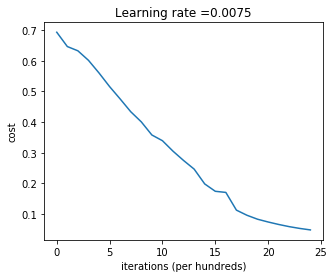

In [30]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), iterations = 2500)

In [42]:
def predict(X,Y,parameters):
    
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    b1 = parameters["b1"]
    b2 = parameters["b2"]
    
    A1,cache1 = linear_activation_forward(X,W1,b1,activation = "relu")
    A2,cache2 = linear_activation_forward(A1,W2,b2,activation = "sigmoid")
    
    print(A2)
    
    count = 0
    
    for x in range(len(Y)):
        if(A2[0,x] == Y[0,x]):
            count = count + 1;
        
    return (count/Y.shape[1]) * 100

In [43]:
pred_train = predict(train_x, train_y, parameters)
print(pred_train)

0.0
